# LDA Topic Modelling from Hansard
## Using LDA to try to extract topics from unlabelled UK parliamentary debates.

### Data preparation
A single-day example of the data can be found in `/data/2016-01-14.json` to make following this more clear.

In [1]:
import lzma
import pickle
from pprint import pprint

raw_data = None
with lzma.open(f"../data/2016-today.xz", "rb") as f:
    raw_data = pickle.load(f)

# Check loaded successfully by printing date of first 2 days in data.
pprint(raw_data[0]["date"])
pprint(raw_data[1]["date"])

'2016-01-05'
'2016-01-06'


Here we recursively loop through the "debates" as they have a nested structure. The problem we face here is that some things Hansard lists as "debates" are/have collections of debates or even just statements. So we try to filter down to the debates on the deepest level and those which have more than 1 contribution so therefore are not statements.

In [2]:
import numpy as np
import pandas as pd


def recurse_debates(debates):
    for deb in debates:  # Loop through debates
        contributions = [
            x for x in deb["items"] if x["type"] == "contribution"
        ]  # Get only the items which have contributions
        if (
            len(contributions) > 1
        ):  # Keep only debates that have more than one contribution.
            yield np.array(
                [deb["title"], " ".join([item["text"] for item in deb["items"]])]
            )  # Yield debate item in format [title, joined text]
        if (
            "child_debates" in deb
        ):  # If debate has child debates loop through those and yield items.
            for item in recurse_debates(deb["child_debates"]):
                yield item


def generate_debates(raw_data):
    for day in raw_data:  # Loop through days in data
        for item in recurse_debates(day["debates"]):
            yield item  # Yield each debate item


df = pd.DataFrame(list(generate_debates(raw_data)), columns=["title", "text"])
df

,title,text
0,Out-of-hospital Care,1. What progress his Department has made on i...
1,GP Services,2. What progress his Department is making on ...
2,Hospital Trusts: Deficits,3. What proportion of hospital trusts are in ...
3,Rare Diseases,4. How many people have diseases classified b...
4,Social Care Budgets: A&E Attendance,5. What assessment he has made of the effect ...
...,...,...
13988,Education Recovery,"With permission, Mr Deputy Speaker, I will mak..."
13989,Official Development Assistance,Application for emergency debate (Standing Ord...
13990,Points of Order,"On a point of order, Mr Deputy Speaker. This i..."
13991,Advanced Research and Invention Agency Bill,[Relevant documents: Third Report of the Scien...


### Preprocessing
Preprocessing is at first done with [Gensim's preprocessing](https://radimrehurek.com/gensim/parsing/preprocessing.html) which does all of the usual removal of unwanted chars and stopwords, as well as tokenisation and stemming.

In [3]:
from gensim.parsing.preprocessing import preprocess_documents

# Grab just the text from the original data.
processed_corp = preprocess_documents(df["text"])
print(processed_corp[0])

['progress', 'depart', 'integr', 'improv', 'care', 'provid', 'outsid', 'hospit', 'happi', 'new', 'year', 'speaker—and', 'happi', 'new', 'year', 'familiar', 'face', 'opposit', 'shadow', 'cabinet', 'govern', 'commit', 'transform', 'hospit', 'care', 'commun', 'seen', 'excel', 'progress', 'area', 'led', 'integr', 'pioneer', 'torbai', 'greenwich', 'govern', 'remain', 'fulli', 'commit', 'deliv', 'integr', 'programm', 'better', 'care', 'fund', 'vanguard', 'seventi', 'cent', 'peopl', 'prefer', 'die', 'home', 'allow', 'peopl', 'die', 'hospit', 'chang', 'netherland', 'ow', 'better', 'social', 'care', 'provid', 'outsid', 'hospit', 'messag', 'minist', 'clinic', 'commiss', 'group', 'try', 'hard', 'bring', 'integr', 'servic', 'grate', 'hon', 'friend', 'rais', 'issu', 'share', 'view', 'want', 'greater', 'choic', 'end', 'life', 'care', 'peopl', 'abl', 'care', 'die', 'place', 'choos', 'appropri', 'need', 'hospic', 'hospit', 'home', 'recent', 'choic', 'review', 'set', 'vision', 'enabl', 'greater', 'choi

Next we write out the document frequencies of each word to determine a suitable filter threshold. LDA is sensitive to very high or low occurring words so we have to filter them out to get a more respresentative picture for each document. I have chosen between 0.1% and 60% to try and filter out some tokens that do not appear to be words at the low end and words that are probably not topical at the top.

In [4]:
from collections import defaultdict

doc_count = 0
frequencies = defaultdict(int)  # The doc frequencies of each token.
for doc in processed_corp:
    doc_count += 1
    doc_contains = set()
    for word in doc:
        doc_contains.add(word)
    for word in doc_contains:
        frequencies[word] += 1

# A sorted array of the format [(token, doc_count, frequency)]. For tokens in more than 2 docs (to reduce size for sorting).
freq_sorted = sorted(
    [
        (key, val, round(val * 100.0 / doc_count, 3))
        for (key, val) in frequencies.items()
        if val > 2
    ],
    key=lambda x: x[1],
)

with open("../logs/sorted_frequencies.txt", "w") as log_file:
    pprint(freq_sorted, log_file)

In [5]:
final_words = [word for (word, count, perc) in freq_sorted if 0.1 < perc < 60]
print(final_words[:50])

['paperless', 'unattain', 'sharm', 'dieter', 'irk', 'bellicos', 'nusra', 'jubeir', 'want—and', 'vermin', '“poor', 'authorities—and', '“foreign', 'jerri', 'activity”', 'principle”', 'decision—that', 'snag', 'tangent', 'not—to', 'shall—', 'sc’', 'faceti', 'investment—and', 'shona', 'people—mani', 'bach', '”other', 'clayton', 'microwav', 'warzon', 'balmor', 'vauxhall’', 'pedestrianis', 'fowler', 'january—remain', 'chickenhal', 'tatti', 'buzzard', 'january—second', 'can—', 'society—and', 'is“no', 'today—on', 'that—h', 'see”', 'law—it', 'abuse”', 'striven', 'vibrat']


There is still clearly some cleaning to be done with this final list of words but we can move on for now. Next we filter all words not in the `final_words` out of the corpus. Then we can, using Gensim, create a dictionary for each word in the corpus (i.e. assign each word a unique number), and covert each document to its "bag of words" representation (i.e remove the ordering from the words and covert it to the numbers from the dictionary).

In [6]:
filtered_corp = []
for doc in processed_corp:
    filtered_corp.append(np.intersect1d(doc, final_words))

print(filtered_corp[:2])

[array(['abil', 'abl', 'absolut', 'achiev', 'ad', 'add', 'admiss', 'admit',
       'adult', 'affect', 'allow', 'antibiot', 'appal', 'appropri',
       'area', 'arrang', 'assembl', 'assist', 'associ', 'author',
       'autumn', 'avail', 'bear', 'best', 'better', 'billion', 'bring',
       'brought', 'cabinet', 'care', 'carefulli', 'cent', 'challeng',
       'chancellor’', 'chang', 'chariti', 'china', 'choic', 'choos',
       'christma', 'clinic', 'come', 'comment', 'commiss', 'commit',
       'commun', 'concern', 'consid', 'constitu', 'context', 'contribut',
       'cornwal', 'council', 'creat', 'death', 'deliv', 'demand',
       'demograph', 'depart', 'determin', 'die', 'differ', 'director',
       'disabl', 'discuss', 'dispens', 'earli', 'elect', 'emerg', 'enabl',
       'end', 'england', 'excel', 'expect', 'experi', 'explor', 'extrem',
       'face', 'facilit', 'fact', 'failur', 'familiar', 'feel', 'feet',
       'final', 'find', 'flood', 'forgotten', 'foundat', 'frequent',
       'f

In [7]:
from gensim import corpora, models

dictionary = corpora.Dictionary(filtered_corp)
corpus_bow = [dictionary.doc2bow(doc) for doc in filtered_corp]
print(list(dictionary.token2id.items())[:10])
print(corpus_bow[10])

[('abil', 0), ('abl', 1), ('absolut', 2), ('achiev', 3), ('ad', 4), ('add', 5), ('admiss', 6), ('admit', 7), ('adult', 8), ('affect', 9)]
[(1, 1), (14, 1), (21, 1), (29, 1), (40, 1), (43, 1), (46, 1), (47, 1), (61, 1), (71, 1), (94, 1), (98, 1), (100, 1), (102, 1), (117, 1), (120, 1), (131, 1), (133, 1), (137, 1), (141, 1), (143, 1), (148, 1), (182, 1), (185, 1), (192, 1), (195, 1), (201, 1), (210, 1), (216, 1), (228, 1), (234, 1), (244, 1), (245, 1), (262, 1), (263, 1), (268, 1), (321, 1), (391, 1), (419, 1), (433, 1), (447, 1), (448, 1), (456, 1), (488, 1), (497, 1), (518, 1), (541, 1), (564, 1), (566, 1), (588, 1), (816, 1), (840, 1), (841, 1), (873, 1), (874, 1), (875, 1), (876, 1), (877, 1), (878, 1), (879, 1), (880, 1), (881, 1), (882, 1), (883, 1), (884, 1), (885, 1), (886, 1), (887, 1), (888, 1), (889, 1), (890, 1), (891, 1), (892, 1), (893, 1)]


### Modelling
Now we have everything we need to perform the topic analysis on our corpus. Here I generate an LDA model for each number of topics in the range 3-25 and extract the top words in each topics for each model. This is so that we can work out which is the optimum number of topics.

In [8]:
from tqdm import tqdm

LDA_models = {}  # LDA models dict with index being the number of topics.
LDA_topics = {}  # Top words in each topic for each of the above models.
num_topics_list = list(range(3, 25))  # list of num_topics to attempt
for i in tqdm(num_topics_list):
    LDA_models[i] = models.LdaMulticore(
        corpus=corpus_bow, id2word=dictionary, num_topics=i, passes=10, random_state=42
    )

    shown_topics = LDA_models[i].show_topics(
        num_topics=i, num_words=300, formatted=False
    )

    # Extract just the word for each topic from the show_topics output form [rank, [word, weight]]
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
print(LDA_topics[num_topics_list[0]])

100%|██████████| 22/22 [1:11:07<00:00, 193.97s/it]

[['make', 'want', 'todai', 'like', 'live', 'futur', 'go', 'come', 'wai', 'hope', 'debat', 'place', 'happen', 'bring', 'question', 'reason', 'rais', 'possibl', 'pai', 'opportun', 'better', 'parti', 'huge', 'thing', 'act', 'welcom', 'real', 'signific', 'term', 'week', 'ask', 'abl', 'countri', 'receiv', 'great', 'number', 'differ', 'life', 'local', 'month', 'chang', 'stand', 'concern', 'manag', 'point', 'power', 'gener', 'public', 'wish', 'grate', 'expect', 'cours', 'discuss', 'person', 'fact', 'let', 'simpli', 'commun', 'good', 'thank', 'recognis', 'increas', 'awai', 'propos', 'give', 'follow', 'clearli', 'help', 'relat', 'set', 'sure', 'start', 'far', 'current', 'absolut', 'believ', 'final', 'mention', 'suggest', 'given', 'result', 'committe', 'seen', 'particularli', 'respons', 'level', 'littl', 'mean', 'open', 'matter', 'area', 'experi', 'remain', 'consid', 'decis', 'constitu', 'fund', 'role', 'dai', 'particular', 'order', 'taken', 'end', 'ago', 'job', 'million', 'think', 'allow', 'ser

A common and effective measure of which model is performing the best here is Coherence which aims to score the semantic similarity of each topic. It does this by assuming semantically related words appear close together, whilst dividing out highly occurring words. Here we will also calculate the [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) for each model. This metric simply calculates the set overlap of the top words in each topic to show when multiple topics are similar. As, generally speaking, less topics should produce a higher coherence and more topics a lower similarity a combination of these two metrics should help us find a good balance of topic numbers without inspecting each model.  
  
We need to be careful not to simply choose the largest difference here without thinking but try to find the point with the best balance for our use case.

In [9]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics. We want a low similarity to ensure diverse and clearly distinct topics.

    Jaccard similarity:
    - J(A,B) = (A ∩ B)/(A ∪ B)
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))

    return float(len(intersection)) / float(len(union))


mean_similarities = []  # Mean similarity for each topic model as list rather than dict.
for i in num_topics_list:
    similarities = []
    for x, topics1 in enumerate(LDA_topics[i]):
        inner_similarities = []
        for y, topics2 in enumerate(LDA_topics[i]):
            if x != y:
                # We do calculate each similarity twice but that will result in the same mean.
                inner_similarities.append(jaccard_similarity(topics1, topics2))
        similarities.append(np.array(inner_similarities).mean())
    mean_similarities.append(np.array(similarities).mean())

print(mean_similarities)

[0.5744314243225673, 0.5525383798866348, 0.5065967830592121, 0.4784138130308788, 0.4852889681019307, 0.460270847265531, 0.46790584068464747, 0.46043331344742355, 0.44286170818500054, 0.45020385148111086, 0.4524420915467141, 0.4441975702660082, 0.4478535375281315, 0.44600182151117224, 0.44558142457559835, 0.4511171005681534, 0.4501862811362078, 0.4444649444509959, 0.4468510003318579, 0.4428675428862939, 0.45286846192587155, 0.46043728211470136]


In [10]:
coherences = [
    models.CoherenceModel(
        model=LDA_models[i], texts=filtered_corp, dictionary=dictionary, coherence="c_v"
    ).get_coherence()
    for i in tqdm(num_topics_list)
]
print(coherences)

100%|██████████| 22/22 [32:54<00:00, 89.73s/it] 

[0.20498385690841833, 0.2479371703676715, 0.24951722278412541, 0.24720885260839265, 0.2562121553121431, 0.2710217426900021, 0.2648445801138077, 0.25807591317075684, 0.24938564266983454, 0.2547315531327571, 0.2586961225546705, 0.22854999843749876, 0.2361363441887834, 0.23309420123984986, 0.2481139435634028, 0.2341423991286367, 0.23070005471678776, 0.24052826398973975, 0.23580282073780984, 0.23446418450423795, 0.24018743694340117, 0.21619891927758197]


In [11]:
optimal_topics_i = np.argmax(coherences - np.array(mean_similarities))
optimal_topics_num = num_topics_list[optimal_topics_i]
print(optimal_topics_num)

8


Text(0, 0.5, 'Metric Value')

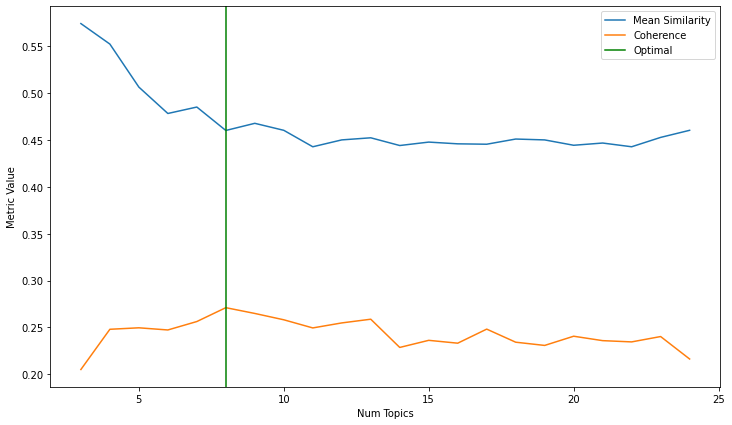

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 7))
ax = plt.axes()
ax.plot(num_topics_list, mean_similarities, label="Mean Similarity")
ax.plot(num_topics_list, coherences, label="Coherence")
plt.axvline(x=optimal_topics_num, color="g", label="Optimal")
plt.legend(fontsize=10)
plt.xlabel("Num Topics")
plt.ylabel("Metric Value")

It appears the number of topics does not drastically affect our data here. 8 seems like a good choice of topic_num but I would consider 13 if I wanted more topics. 8 is fine for now.  
Also our coherence of 0.271 is not good. Let's see if we can improve that after we've taken a look at our model. We should also save our model here so that we don't have to run all this again.

In [13]:
lda_model = LDA_models[optimal_topics_num]
lda_model.save("../models/lda/lda_model_v1_8")

### Inspecting The Model
Firstly let's take a look at the top words from each topic.

In [14]:
from gensim import models

lda_model = models.LdaModel.load("../models/lda/lda_model_v1_8")

topics = lda_model.show_topics(8, num_words=20, formatted=False)
with open("../logs/model_topics.txt", "w") as log_file:
    pprint(topics, log_file)
print(topics[0])

(0, [('todai', 0.0010989505), ('want', 0.0010232902), ('make', 0.0010163883), ('like', 0.0009976184), ('go', 0.0009951722), ('happen', 0.00097563054), ('come', 0.0009694373), ('debat', 0.00096898817), ('great', 0.00096613326), ('better', 0.0009592764), ('real', 0.0009561303), ('bring', 0.00095145556), ('wai', 0.000950383), ('mention', 0.00094314595), ('hope', 0.00094276713), ('good', 0.0009398608), ('commun', 0.000939434), ('opportun', 0.00093891757), ('live', 0.0009349466), ('chang', 0.000932198)])


Now I personally have found this a very difficult method of working out what the topics are. So lets try to see if we can use the top scoring debate titles for each topic as an indicator of the topics extracted by our model.

In [15]:
def generate_top_titles(model, titles, corp, topic_num):
    topic_titles = {x: [] for x in range(topic_num)}
    for i, doc in enumerate(corp):
        topics = model.get_document_topics(dictionary.doc2bow(doc))
        for (topic, prob) in topics:
            topic_titles[topic].append((titles[i], prob))

    topic_titles_sorted = {}
    for topic, titles in topic_titles.items():
        topic_titles_sorted[f'Topic {topic}'] = sorted(titles, key=lambda x: x[1], reverse=True)[:20]

    return pd.DataFrame.from_dict(topic_titles_sorted, orient='index')

df_topic_analysis = generate_top_titles(lda_model, df['title'], processed_corp, 8)
df_topic_analysis

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 0,(Protection of monuments of Captain James Cook...,"(Football Supporters (Access), 0.84961927)","(Arsène Wenger, 0.78927845)",(Football Governance (Supporters’ Participatio...,"(Bradford Bulls and Rugby League, 0.7627429)","(Bredbury Parkway Industrial Estate Extension,...","(Football (Regulation), 0.7504939)","(Dulwich Hamlet Football Club, 0.7373163)","(Tributes: Baroness Jowell, 0.7194389)","(Dame Vera Lynn: National Memorial, 0.6936416)",(Implementation of the 1995 and 2011 Pension A...,"(Cornish Wrestling, 0.6658399)","(Football Super League, 0.6622153)","(Greater Manchester Spatial Framework, 0.64765...","(Cathedrals: Contribution to Local Economies, ...","(Lung Cancer, 0.63434374)","(Queen’s Sapphire Jubilee, 0.60318935)","(Billy McNeill MBE, 0.6026106)","(Peterborough United: Covid-19, 0.5972225)","(Jamie and Andy Murray: Sporting Legacy, 0.597..."
Topic 1,"(Catalonia, 0.9887549)","(Events at US Capitol, 0.86396384)","(Catalonia, 0.82455003)","(Catalonia, 0.8115951)","(Catalonia, 0.76714814)","(Imprisonment of Catalan Leaders, 0.7037443)","(Catalonia, 0.62282604)","(UK-US Extradition Agreement, 0.6150844)","(Resignation of UK Ambassador to USA, 0.5648321)","(Russia, 0.56183267)","(President of Belarus, 0.55255324)","(Hong Kong, 0.53926474)","(Turkey, 0.52846503)",(Northern Ireland Backstop: Conditional Interp...,"(Russian Interference in UK Politics, 0.5205954)","(Interpol Presidency Election, 0.5193091)","(British Passport Fraud, 0.5130603)",(Intelligence and Security Committee of Parli...,"(Hong Kong, 0.5110772)","(Human Rights: Xinjiang, 0.5094284)"
Topic 2,"(Counter-Daesh Update, 0.9997357)","(Counter-Daesh Update, 0.99972636)","(Yemen, 0.999725)","(Carrier Strike Group Deployment, 0.9997181)","(Counter-Daesh Update, 0.9997125)","(Israel and Gaza: Ceasefire, 0.99971074)","(Counter-Daesh Update, 0.9997027)","(Counter-Daesh Quarterly Update, 0.9996804)","(Liberation of Mosul, 0.99967533)","(Syria: Madaya, 0.9996663)","(Raqqa and Daesh, 0.99965465)","(UN Mission in Mali: Armed Forces Deployment, ...","(Royal Naval Deployment: Mediterranean, 0.999646)","(Yemen, 0.99963766)","(Syria: Security Situation, 0.99962)","(Yemen, 0.9996157)","(Yemen, 0.99960226)","(Hurricane Irma, 0.9995936)","(Yemen, 0.9995901)","(Yemen: Aid Funding, 0.9995897)"
Topic 3,"(House of Lords: Membership, 0.5896524)","(Pensions, 0.5848196)","(Rhondda, 0.5084572)",(Pensions Uprating (UK Pensioners Living Over...,"(Welfare (Terminal Illness), 0.47694856)","(State Pensions: UK Expatriates, 0.47601292)",(Access to Welfare (Terminal Illness Definiti...,"(Home Ownership, 0.46272177)",(National Insurance Contributions (Termination...,"(Postal Voting System, 0.4376003)","(State Pension Age, 0.42055497)",(Electoral Reform (Proportional Representation...,"(Equitable Life, 0.40773168)","(Mortgage Prisoners, 0.40554884)","(Pension Arrangements for Women, 0.4028842)","(Pension Liabilities: Plumbing Industry, 0.373...","(Pension Transition Arrangements, 0.3730082)","(Free TV Licences: Over-75s, 0.3686298)","(Equitable Life, 0.36587727)",(Child Maintenance (Assessment of Parents’ Inc...
Topic 4,(Local Government Responsibilities: Public Se...,"(Schools Update, 0.9998129)","(Educational Settings, 0.999809)","(Covid-19: Educational Settings, 0.9997805)","(Students’ Return to Universities, 0.99977833)",(National Funding Formula: Schools/High Needs...,"(Education Settings: Wider Opening, 0.99977225)","(Education: Return in January, 0.99977154)",(Schools and Colleges: Qualification Results a...,"(Education Settings: Autumn Opening, 0.9997339)","(Schools: National Funding Formula, 0.9997092)",(Covid-19 Lockdown: Homelessness and Rough Sle...,"(Timpson Review of School Exclusion, 0.999692)","(Support for University Students: Covid-19, 0...","(Supporting Disadvantaged Families, 0.9996638)","(Deaths of Homeless People, 0.99966013)","(Women’s Health Strategy, 0.99965715)","(Education: Public Funding, 0.9996502)","(Fr

From this it seems much easier to me to see which topics are which. Here is my assessment of each, see if you agree:
| Topic | Guessed |
| ----------- | ----------- |
| 0 | Sport / Culture |
| 1 | Foreign Events |
| 2 | Terrorism / Military |
| 3 | Tax / Welfare |
| 4 | Education / Health |
| 5 | ??? |
| 6 | Admin of parliament? |
| 7 | Trade / Exports |

### Improving the model
Now we have our baseline model we can get into the meat of the problem of making good topics not just topics at all. There are a few good ways to improve the model here imo:
- We have already seen from our `logs/sorted_frequencies.txt` that there are words in our corpus which are not being preprocessed correctly by gensim's standard preprocessing function. This can easily be resolved with a bit of regex.
- There are some words high up in the frequency list that are clearly supposed to be used in phrases and would be more meaningful this way e.g. "right honourable" "Secretary of ...". Therefore adding bigrams and trigrams to the data should help our algorithm extract meaning.
- We can use the "Mallet" version of the LDA algorithm which generally produces a higher coherence at a trade off of speed.
- Finally we can tune the model parameters. Most likely for minimal gain.  
  
Starting with the first one we can see from the following string that Gensim's preprocess function doesn't handle some unicode characters well. Let's handle these exceptions ourselves and try to see how that affects the data.

In [16]:
from gensim.parsing.preprocessing import preprocess_string as g_preprocess_string
import re

# This string from our corpus does not appear to be preprocessed correctly
print(g_preprocess_string("This week, the Home Secretary said on “The Andrew Marr Show”:“I think at this stage…this isn’t about breaking codes"))

re_unicode_chars = re.compile(r'[—”“…’]')

# Redefining a new function that subs out those unhandled unicode chars.
def preprocess_string(s):
    s = re_unicode_chars.sub(' ', s)
    return g_preprocess_string(s)

print(preprocess_string("This week, the Home Secretary said on “The Andrew Marr Show”:“I think at this stage…this isn’t about breaking codes"))


['week', 'home', 'secretari', 'said', '“the', 'andrew', 'marr', 'show”', 'think', 'stage…thi', 'isn’t', 'break', 'code']
['week', 'home', 'secretari', 'said', 'andrew', 'marr', 'think', 'stage', 'isn', 'break', 'code']


Excellent. Thanks to this we can also afford to be much more lenient with the filtering as we do not need to filter out tokens which were incorrect due to these unicode mistakes. I will use Gensim's [dictionary.filter_extremes()](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes) with the default values for this. Now let's see how this affects the coherence.

In [17]:
from collections import defaultdict
from tqdm import tqdm

def preprocess_docs(docs):
    # preprocess the docs whilst counting the docs for each word
    doc_counts = defaultdict(int)
    processed_corp = []
    for doc in tqdm(docs):
        doc_contains = set() # The set of words in the doc
        words = preprocess_string(doc)
        processed_corp.append(words)
        for word in words:
            doc_contains.add(word)
        for word in doc_contains:
            doc_counts[word] += 1
    return doc_counts, processed_corp

doc_counts, processed_corp = preprocess_docs(df['text'])

100%|██████████| 13993/13993 [04:48<00:00, 48.56it/s]


In [18]:
from gensim import corpora, models

def generate_dict_bow(corp):
    dictionary = corpora.Dictionary(corp)
    dictionary.filter_extremes()
    corpus_bow = [dictionary.doc2bow(doc) for doc in corp]
    return (dictionary, corpus_bow)

In [39]:
dictionary, corpus_bow = generate_dict_bow(processed_corp)
lda_model = models.LdaMulticore(corpus=corpus_bow,
                             id2word=dictionary,
                             num_topics=8,
                             passes=10,
                             random_state=42)
coherence = models.CoherenceModel(model=lda_model, texts=processed_corp, dictionary=dictionary, coherence='c_v').get_coherence()
print(coherence)

0.4035534834115951


0.404 is much better than the 0.271 from before. That shows how important clean data is for machine learning. Now lets try adding phrases.

In [60]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

def add_phrases(corp, threshold=100):
    # Add bigrams to corpus. Can be called on a corpus with bigrams to add trigrams etc.
    # Only adds bigrams that appear 5 times at least.
    # Higher threshold means less phrases added.
    bigram = Phrases(corp, threshold=threshold)
    bigram_mod = Phraser(bigram)

    return bigram_mod[corp]

In [62]:
bigram_corp = add_phrases(processed_corp)
dictionary, corpus_bow = generate_dict_bow(bigram_corp)
lda_model = models.LdaMulticore(corpus=corpus_bow,
                             id2word=dictionary,
                             num_topics=8,
                             passes=10,
                             random_state=42)
coherence = models.CoherenceModel(model=lda_model, texts=bigram_corp, dictionary=dictionary, coherence='c_v').get_coherence()
print(coherence)

0.42605246719122203


0.426 - another improvement, albiet not as big a jump as last time. I did also try adding trigrams to the data but it reduced the coherence. This can be because if you keep adding n-grams it makes the model less generalised and so can perform worse. Imagine if we turned each document into a massive phrase the model would be useless despite us capturing all the positional information. We ideally want to capture the phrases that become more relevant together than apart only.  
  
Now to get LDA Mallet working with Gensim I had to manually install version 3 of Gensim separately as unfortunetly it is [no longer supported](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4#15-removed-third-party-wrappers) in v4. So the following code will not work for you unless you do the same and install it under `gensim_3`. You can also read the output without running the code and load the model later if you are running the code yourself. I have also set the `optimize_interval` here so that the mallet algorithm will learn our hyperparameters during training.

In [71]:
from gensim_3.models.wrappers import LdaMallet

mallet_path = "~/Downloads/mallet-2.0.8/bin/mallet"
lda_model = LdaMallet(mallet_path,
                    corpus=corpus_bow,
                    id2word=dictionary,
                    num_topics=8,
                    optimize_interval=10,
                    random_seed=42)
coherence = models.CoherenceModel(model=lda_model, texts=bigram_corp, dictionary=dictionary, coherence='c_v').get_coherence()
print(coherence)

0.4912423969945743


So overall we've managed to improve our coherence from 0.271 to 0.491, not bad! Lets have a look at how the topics look now.

In [72]:
topics = lda_model.show_topics(8, num_words=20, formatted=False)
with open("../logs/model_topics_v2.txt", "w") as log_file:
    pprint(topics, log_file)
print(topics[0])

(0, [('health', 0.02049537597540915), ('care', 0.015126719775953801), ('nh', 0.013498698748319812), ('servic', 0.008144342017877514), ('hospit', 0.007676166810190967), ('mental', 0.00589826616290167), ('patient', 0.005507414009878285), ('social', 0.0052881554850115085), ('public', 0.005090081358682584), ('week', 0.005079489159413658), ('test', 0.005064130470473715), ('local', 0.005048242171570325), ('covid', 0.004849108825314509), ('vaccin', 0.004721472824123945), ('staff', 0.004701347645512986), ('famili', 0.004064756469450508), ('live', 0.004064756469450508), ('dai', 0.004057871539925706), ('debat', 0.004027683772009266), ('commun', 0.0036585456274871807)])


In [73]:
from gensim_3.models.wrappers.ldamallet import malletmodel2ldamodel

df_topic_analysis = generate_top_titles(malletmodel2ldamodel(lda_model), df['title'], bigram_corp, 8)
df_topic_analysis

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 0,"(Queen Mary’s Hospital: Urgent Care Services, ...","(Mental Health Services, 0.9965546709363242)","(Non-covid-19 Healthcare Treatment, 0.99626439...","(Cancer Services, 0.9960664650961587)","(Cancer Referral Times, 0.9960288803581504)","(Covid-19: Bereavement Services, 0.99597058492...","(NHS Workers: Mental Health, 0.9958654674917268)","(Covid-19 Testing Capacity, 0.9953683862043107)","(Autism, 0.995322476100414)","(Social Care: Covid-19, 0.9948326886713915)","(A&E Targets, 0.9946408753940716)","(Public Health Protection, 0.9945634491025306)","(Lyme Disease, 0.9940631161952346)","(Hospitals in Special Measures, 0.993913882640...","(Low-risk Medicines, 0.9938347047053467)","(Covid-19 Testing, 0.993714532766808)","(Prostate Cancer, 0.9935497117477533)","(A&E: West Midlands, 0.9933979304776133)","(Dental Surgery: Children, 0.9929881865520442)","(Health Inequalities, 0.9929408546014236)"
Topic 1,"(Campaign against Daesh, 0.9984535416667223)","(Saudi Arabia: Diplomatic Relations, 0.9965287...","(Iraq and Syria: RAF Campaign, 0.9965195531177...","(Armed Conflicts: Heritage, Minorities and Hum...","(Israel and Palestine, 0.9964516251454489)","(Yemen, 0.9964456369995099)","(Kashmir, 0.9962657297788418)","(Nagorno-Karabakh, 0.9961265268237661)","(Turkey (Afrin), 0.996124037122504)","(Hezbollah, 0.9960512282701269)","(Ethiopia, 0.9955123284125935)","(Burundian Refugee Safety, 0.9954897216695188)","(Sudan and South Sudan, 0.9951245764045753)","(Freedom of Worship (Commonwealth), 0.99490881...","(Yemen, 0.9948843764225701)","(West Bank, 0.9948352951000273)","(Daesh, 0.9940362781342017)","(Middle East, 0.9939114928997818)","(Daesh, 0.9937626133263967)","(Refugees: Middle East, 0.9935149878363986)"
Topic 2,(Northern Ireland (Executive Formation and Exe...,(Investigatory Powers Bill (Programme) (No. 2)...,(Terrorist Offenders (Restriction of Early Rel...,"(Personal Statement, 0.9934730933959418)","(Business without Debate, 0.9890486675655648)","(Constituency Boundary Review, 0.9856809876887...",(Cultural Property (Armed Conflicts) Bill [Lor...,"(Point of Order, 0.9849754988876986)","(Remote Division result: New Clause 2, 0.98442...","(Delegated Legislation, 0.9827368528883919)","(Voter Registration: Proof of Identity, 0.9817...","(Point of Order, 0.9810367407434648)","(Rectification Procedure, 0.9801825481808294)","(Point of Order, 0.9792349192678231)","(Privileges, 0.9781196057752485)","(Business without Debate, 0.9780075175185589)",(Sittings in Westminster Hall (Suspension) (No...,"(Members’ Interests, 0.9773211096866233)","(Business of the House (24, 25, 26 and 27 Apr...","(INTERNATIONAL TRADE Committee, 0.976341520531..."
Topic 3,"(Disadvantaged Young People, 0.9972619580807985)","(High-performing Teachers, 0.9971905609559713)","(Homes for Social Rent, 0.9970707960963573)","(School Funding, 0.9966066120526399)","(Nursery Schools, 0.9962543771084016)","(School Places, 0.9962518551409824)","(Maintained Schools, 0.9957758577124045)","(GCSE Pass Rate (Northamptonshire), 0.99574361...","(Teacher Shortages, 0.9957259686405763)","(Social Mobility, 0.9954990328890604)","(The future of maintained nursery schools, 0.9...","(Affordable Homes, 0.9951690527632537)","(Children in Need, 0.9951460231866106)","(Homelessness, 0.9948520951423129)","(Free Childcare, 0.9947088598969535)","(School Funding Formula (London), 0.9945859769...","(Children from Disadvantaged Backgrounds, 0.99...","(Pupils from Disadvantaged Backgrounds, 0.9936...","(School Curriculum, 0.9935830647497206)","(Pupil Premium, 0.9934497288876967)"
Topic 4,"(Transport Infrastructure: North England, 0.99...","(Rail Electrification, 0.9970418521895494)","(Train Timetable Changes, 0.9970118122617418)","(Rail Performance, 0.9969932166751538)","(Rolling Stock, 0.9968887579007342)","(Railway Infrastructure, 0.9968234094679168)","(Superfast Broadband, 0.9965275637992755)","(Energy-Intensive Industries: Decarbonisation,...","(Rail Link